In [1]:
import torch
import sys
import os
sys.path.append(os.path.abspath('../..'))
from data import PVWeatherGenerator, SystemLoader


In [2]:
# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS_FOLD = 7
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_SYSTEMS = 7
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

In [3]:
generator = PVWeatherGenerator(
    coords=CIRCLE_COORDS,
    radius=RADIUS,
    day_init=DAY_INIT,
    n_systems=N_SYSTEMS,
    n_days=365,
    minute_interval=MINUTE_INTERVAL,
)
df = generator.df

==> Loading data
==> Loaded data in: 0 m : 20 sec



In [22]:
individual_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD)
loader = SystemLoader(df, train_interval=individual_interval)

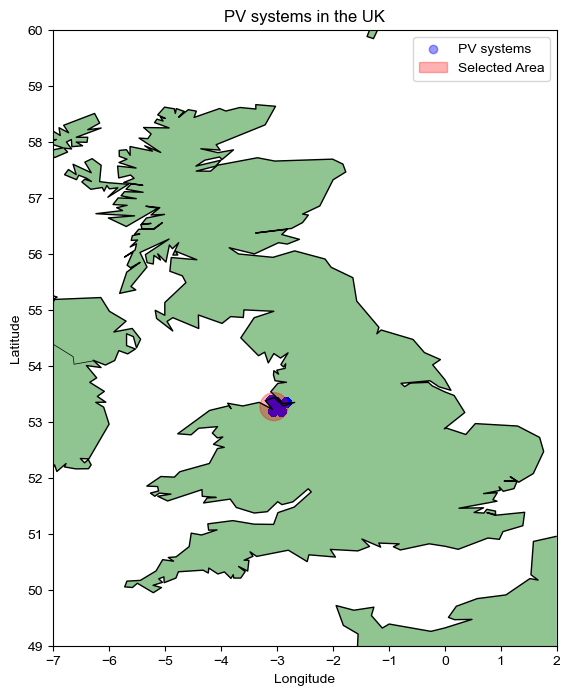

In [5]:
from pv_plot import plot_grid
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25
plot_grid(df, CIRCLE_COORDS, RADIUS)

In [6]:
x, _,_,_,_,_ = next(iter(loader))
d = x.shape[1]
print(d)

6


In [7]:
from kernels import get_mean_covar_weather

num_tasks = N_SYSTEMS
num_latents = N_SYSTEMS // 2 + 1
mean, covar = get_mean_covar_weather(num_latents=num_latents,
                                      d=d,
                                      combine='product')

interval = 10

Using CPU
Iter 10/15 - Loss: 5.2566639113934


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.


NLPD: torch.Size([504, 10])
NLPD Single: torch.Size([72])


findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

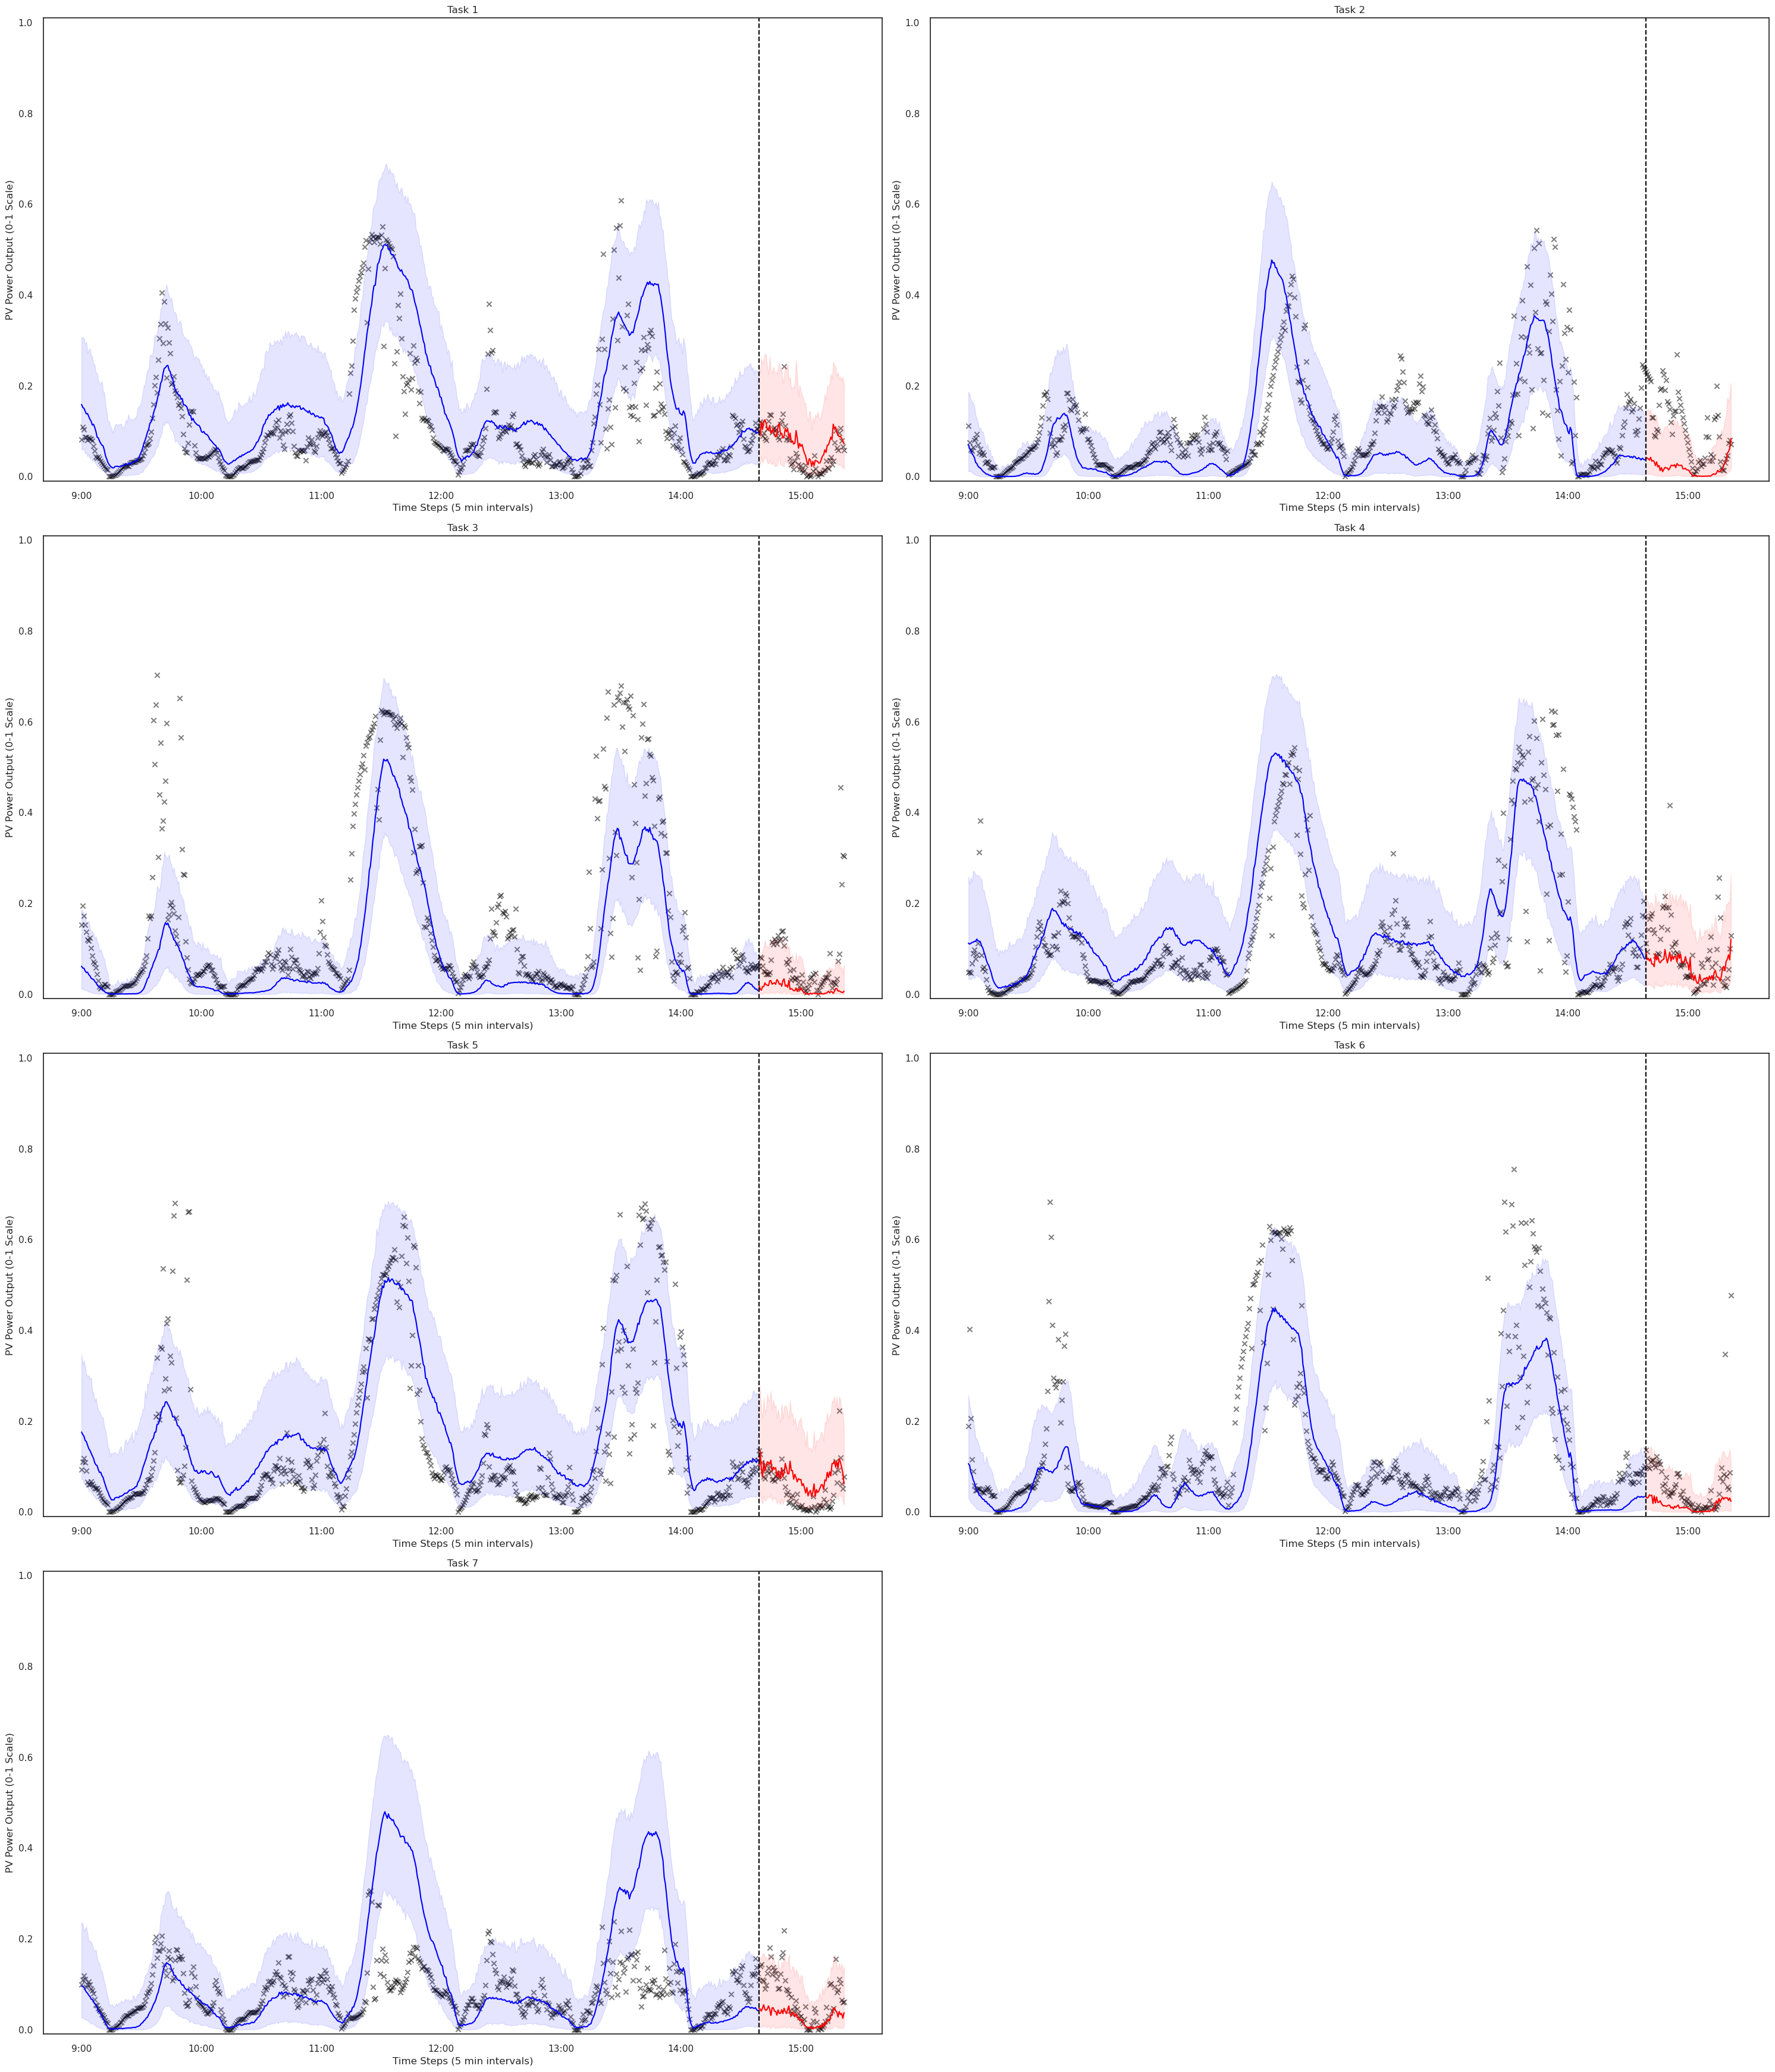

findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: Font family 'CMU Serif' not found.
findfont: 

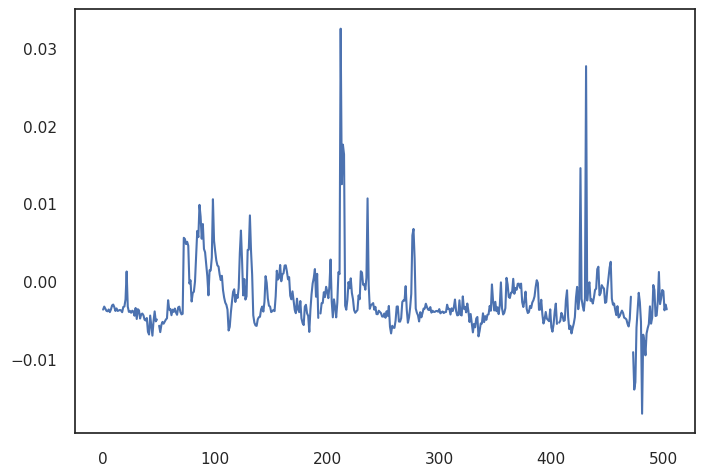

In [32]:
from matplotlib import pyplot as plt
import numpy as np
from models import HadamardGPModel, LSTM, fit_bayesian_ridge, fit_xgboost
from likelihoods import HadamardBetaLikelihood
from gpytorch.metrics import negative_log_predictive_density as NLPD

for X_tr, Y_tr, X_te, Y_te, T_tr, T_te in loader:

    fig, ax = plt.subplots(num_tasks // 2 + 1, 2, figsize=(30, 5 * (num_tasks)) )
    plt.rcParams['font.serif'] = ['Times New Roman']

    ax = ax.flatten()
    mean, covar = get_mean_covar_weather(num_latents, d, 'product')
    model = HadamardGPModel(
        X=X_tr[::interval],
        y=Y_tr[::interval],
        mean_module=mean,
        covar_module=covar,
        likelihood=HadamardBetaLikelihood(num_tasks=num_tasks, scale=30),
        num_tasks=num_tasks,
        num_latents=num_latents,
        learn_inducing_locations=True,
        inducing_proportion=1,
        jitter=1e-2,
    )
    model.set_cpu()
    model.fit(n_iter=15, 
          lr=0.2, 
          task_indices=T_tr[::interval],
          verbose=True)
    model.predict(X_tr, T_tr)
    

    for i in range(num_tasks):
        _, y_tr, _, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t_tr, t_te = torch.arange(n_tr), torch.arange(n_tr, n_tr+n_te)

        y_pred_tr, lower_tr, upper_tr = model.get_i_prediction(i, T_tr)
        ax[i].scatter(t_tr, y_tr, color='black', marker='x', label='Observed Data', alpha=0.5)
        ax[i].scatter(t_te, y_te, color='black', marker='x', alpha=0.5)
        ax[i].plot(t_tr, y_pred_tr, color='blue', label='Predicted Mean')
        ax[i].fill_between(t_tr, lower_tr, upper_tr, color='blue', alpha=0.1, label='95% CI')
    
    model.predict(X_te, T_te)
    pred_dist = model.predict_dist()
    nlpd = NLPD(pred_dist, Y_te).t()
    print(f'NLPD: {nlpd.shape}')
    nlpd = nlpd.median(dim=1).values
    nlpd_single = nlpd[T_te == 0]
    print(f'NLPD Single: {nlpd_single.shape}')
    # replace inf with nan
    nlpd[(nlpd == torch.inf) | (nlpd == -torch.inf)] = torch.nan
    

    for i in range(num_tasks):
        x_tr, y_tr, x_te, y_te = loader.train_test_split_individual(i)
        n_tr, n_te = y_tr.shape[0], y_te.shape[0]
        t_tr, t_te = torch.arange(n_tr), torch.arange(n_tr, n_tr+n_te)

        y_pred_te, lower_te, upper_te = model.get_i_prediction(i, T_te)
        if i == 0:
            ax[i].plot(t_te, y_pred_te, color='red', label='Hadamard GP')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1, label='95% CI (Hadamard GP)')
        else:
            ax[i].plot(t_te, y_pred_te, color='red')
            ax[i].fill_between(t_te, lower_te, upper_te, color='red', alpha=0.1)
        ax[i].axvline(n_tr, color='black', linestyle='--', label='Train/Test Split')
        # set ticks to be every 12th tick where first point is 8am and last point per day is 4pm
        ax[i].set_xticklabels([f'{int((t % 96) / 12) + 8}:00' for t in t_tr[::12]])
        ax[i].set_ylim(-0.01, 1.01)
    

        ax[i].set_xlabel('Time Steps (5 min intervals)')
        ax[i].set_ylabel('PV Power Output (0-1 Scale)')
        ax[i].set_title(f'Task {i+1}')
        

        # model_lstm = LSTM(x_tr[:,:-1].float(), y_tr.float())
        # model_lstm.fit()
        # y_pred_lstm = model_lstm.predict(x_te[:,:-1].float(), y_te.float())
        # y_pred_xgb = fit_xgboost(x_tr[:,:-1], y_tr, x_te[:,:-1])
        # y_pred_brr, var_brr = fit_bayesian_ridge(x_tr[:,:-1], y_tr, x_te[:,:-1])


        # ax[i].plot(t_te, y_pred_lstm, color='green', label='LSTM')
        # ax[i].plot(t_te, y_pred_xgb, color='orange', label='XGBoost')
        # ax[i].plot(t_te, y_pred_brr, color='purple', label='Bayesian Ridge')
        # ax[i].fill_between(t_te, y_pred_brr -1.96 * np.sqrt(var_brr), y_pred_brr + 1.96 * np.sqrt(var_brr), color='purple', alpha=0.1, label='95% CI (Bayesian Ridge)')

        # ax[i].legend(loc='upper left')
     
    # remove unused axes past the number of tasks
    for i in range(num_tasks, len(ax)):
        ax[i].axis('off')
    break

plt.tight_layout()
plt.show()

plt.plot(nlpd)
plt.show()

In [25]:
nlpd.isinf().sum().sum()

tensor(290)

In [27]:
np.log(0)

-inf

In [9]:
from data.utils import store_gp_module_parameters
store_gp_module_parameters(model)

{'covar_module.kernels.0.outputscale': array([0.6436, 0.3066, 0.182 , 0.2533], dtype=float32),
 'covar_module.kernels.0.base_kernel.lengthscale': array([3.4684, 5.615 , 4.5347, 5.7635], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.outputscale': array([0.2691, 0.1659, 0.2301, 0.1642], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.base_kernel.lengthscale': array([1.584 , 1.597 , 1.2321, 1.606 ], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.0.base_kernel.period_length': array([1.2151, 1.4546, 1.0182, 1.4681], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.1.outputscale': array([0.2691, 0.1659, 0.2301, 0.1642], dtype=float32),
 'covar_module.kernels.1.kernels.0.kernels.1.base_kernel.lengthscale': array([1000.0024, 1000.0021,  999.9812, 1000.0004], dtype=float32),
 'covar_module.kernels.1.kernels.1.outputscale': array([0.8063, 0.4268, 0.1542, 0.4309], dtype=float32),
 'covar_module.kernels.1.kernels.1.base_kernel.lengthscale': array([